In [11]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

In [12]:
import sys
sys.path.append('../scripts')
from utils import predict, predict_multi_line_text, load_data

sys.path.append('../')
from config import entity_to_acronyms, acronyms_to_entities

In [13]:
# from importlib import reload

# import utils
# reload(utils)

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [15]:
from config import entity_to_acronyms, acronyms_to_entities

In [16]:
data_dir = '../data'

In [17]:
(train_sequences_padded, train_labels), (val_sequences_padded, val_labels), (test_sequences_padded, test_labels), label_to_index, index_to_label = load_data(data_dir)

In [18]:
if train_sequences_padded.shape[1] != train_labels.shape[1]:
    print('Sequence length mismatch')

In [19]:
# Load the tokenizer from file
with open('../data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Load the BioWordVec vectors

In [20]:
path_to_vectors = os.path.join(data_dir, 'embedding_vectors', 'BioWordVec_PubMed_MIMICIII_d200.vec.bin')
biowv = gensim.models.KeyedVectors.load_word2vec_format(path_to_vectors, binary=True)

## Create embedding layer using the BioWordVec vectors

In [22]:
embedding_matrix = np.zeros((INPUT_DIM, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in biowv.index_to_key:
        embedding_matrix[i] = biowv[word]
        
embedding_layer = tf.keras.layers.Embedding(
    INPUT_DIM,
    EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LENGTH,
    trainable=False
)

## Model parameters

In [23]:
INPUT_DIM = len(tokenizer.word_index)+1
EMBEDDING_DIM = 200
NUM_CLASSES = len(label_to_index)
MAX_LENGTH = train_sequences_padded.shape[1]

LSTM_UNITS = 64
DENSE_UNITS = 64

DROPOUT_RATE = 0.2
BATCH_SIZE = 32
EPOCHS = 20

## Building Model

In [24]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_positives / (predicted_positives + K.epsilon())
    return _precision

def recall(y_true, y_pred):
    """Compute recall metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    """Compute f1-score metric"""
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    f1_score = 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))
    return f1_score

In [25]:

import tensorflow as tf

# Define the model architecture
model = tf.keras.models.Sequential([
    
    # Add an embedding layer to learn the representations of words in the input text
    embedding_layer,
    
    # Add a Bidirectional LSTM layer to capture contextual information from both directions
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)),
    
    # Add a TimeDistributed dense layer to apply a dense layer to each time step of the LSTM output
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=DENSE_UNITS, activation='relu')),
    
    # Add a dropout layer to reduce overfitting
    tf.keras.layers.Dropout(rate=DROPOUT_RATE),
    
    # Add a TimeDistributed dense layer to apply a dense layer to each time step of the previous dense layer output
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax'))
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          1393800   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         135680    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 64)          8256      
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 79)          5135      
 tributed)                                                       
                                                        

In [26]:
# Train the model
history = model.fit(
    train_sequences_padded, 
    train_labels, 
    epochs=EPOCHS, 
    validation_data=(val_sequences_padded, val_labels)
)

Epoch 1/20


2023-04-08 20:16:54.418932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


95/95 [==============================] - 7s 49ms/step - loss: 1.0847 - accuracy: 0.8925 - precision: 0.8114 - recall: 0.7080 - f1_score: 0.7481 - val_loss: 0.3777 - val_accuracy: 0.9129 - val_precision: 0.9868 - val_recall: 0.8903 - val_f1_score: 0.9360
Epoch 2/20
95/95 [==============================] - 4s 45ms/step - loss: 0.3450 - accuracy: 0.9122 - precision: 0.9926 - recall: 0.8862 - f1_score: 0.9363 - val_loss: 0.3320 - val_accuracy: 0.9211 - val_precision: 0.9848 - val_recall: 0.8966 - val_f1_score: 0.9386
Epoch 3/20
95/95 [==============================] - 4s 45ms/step - loss: 0.2898 - accuracy: 0.9220 - precision: 0.9906 - recall: 0.8927 - f1_score: 0.9391 - val_loss: 0.3119 - val_accuracy: 0.9258 - val_precision: 0.9811 - val_recall: 0.9017 - val_f1_score: 0.9397
Epoch 4/20
95/95 [==============================] - 4s 45ms/step - loss: 0.2563 - accuracy: 0.9291 - precision: 0.9883 - recall: 0.8992 - f1_score: 0.9416 - val_loss: 0.3007 - val_accuracy: 0.9296 - val_precision: 0.

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(['train', 'val'], loc='best')
    
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['train', 'val'], loc='best')
    
    axs[1, 0].plot(history.history['recall'])
    axs[1, 0].plot(history.history['val_recall'])
    axs[1, 0].set_title('Model Recall')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['train', 'val'], loc='best')
    
    axs[1, 1].plot(history.history['f1_score'])
    axs[1, 1].plot(history.history['val_f1_score'])
    axs[1, 1].set_title('Model F1 Score')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].legend(['train', 'val'], loc='best')
    
    plt.tight_layout()
    plt.show()


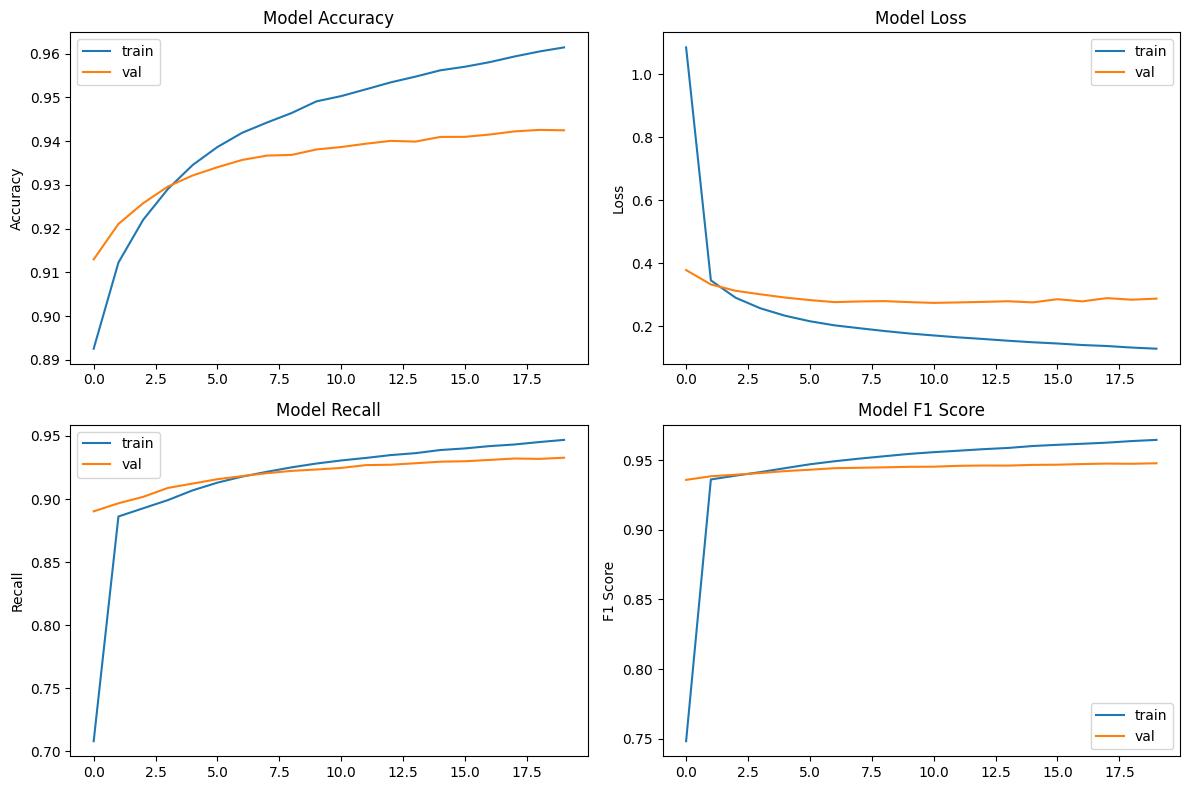

In [28]:
# Plot the training history
plot_graphs(history)

In [29]:
from sklearn.metrics import classification_report

# Get the model predictions
y_pred = model.predict(test_sequences_padded)

# Convert the predictions from one-hot encoded format to the label format
y_pred_labels = np.argmax(y_pred, axis=2)
test_labels_labels = np.argmax(test_labels, axis=2)

# Print the classification report
print(classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0))


28/28 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           1       0.20      0.07      0.10        15
           2       0.50      0.51      0.51        37
           3       0.87      0.92      0.89        36
           4       0.20      0.25      0.22         4
           6       0.47      0.53      0.50       467
           7       0.65      0.64      0.65       100
           8       0.40      0.50      0.44        16
           9       0.50      0.05      0.10        56
          10       0.42      0.54      0.47        97
          11       0.35      0.25      0.29       478
          12       0.58      0.47      0.52       684
          13       0.40      0.29      0.34       236
          14       0.56      0.42      0.48        65
          15       0.34      0.36      0.35        45
          16       0.00      0.00      0.00        16
          17       0.50      0.18      0.27        11
          19       0.24    

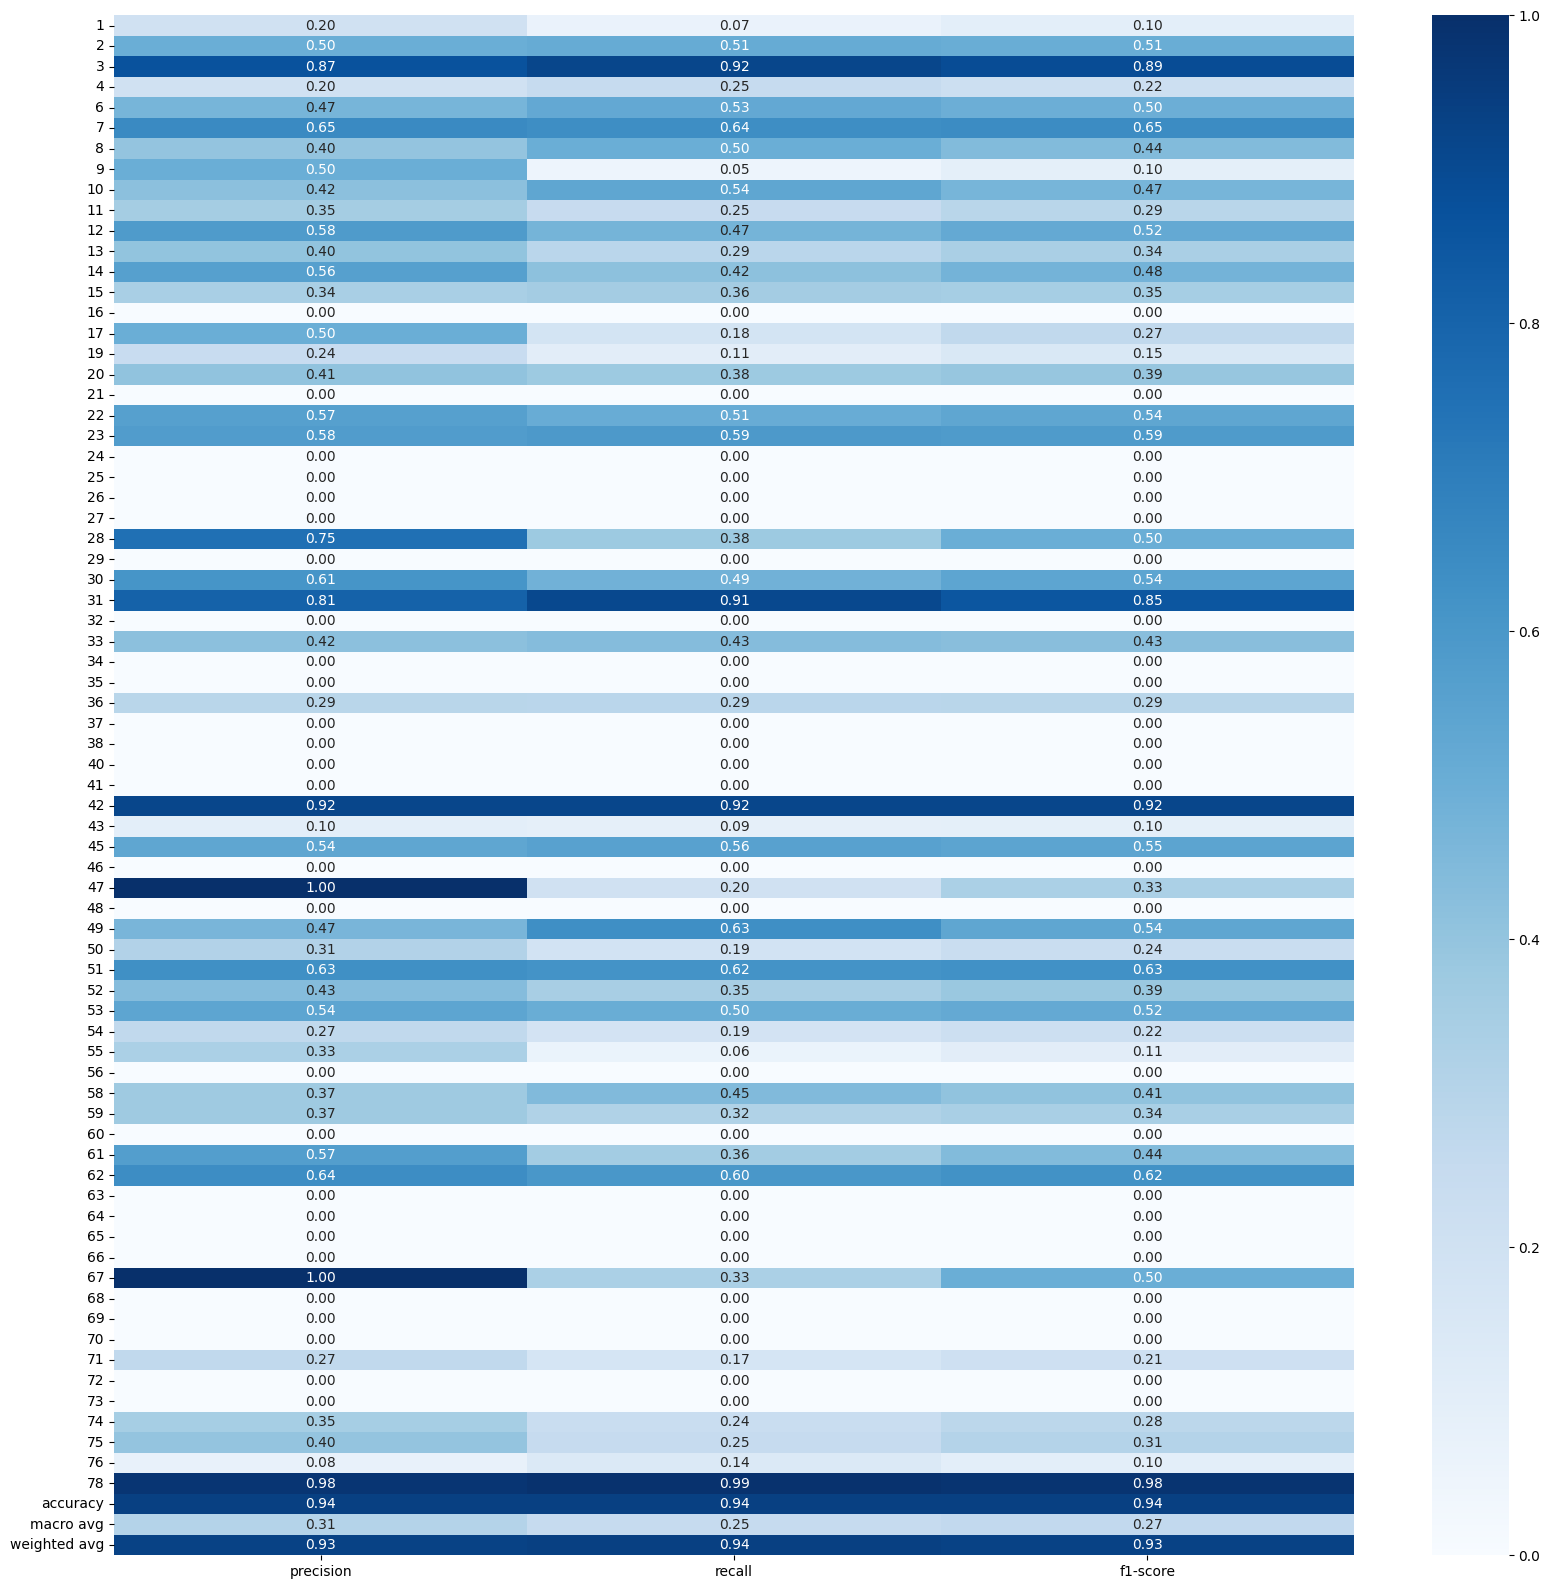

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0, output_dict=True)
plt.subplots(figsize=(20, 20))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.show()


In the case of NER task, all three metrics - precision, recall, and F1 score - are important.

* Precision measures the proportion of predicted entities that are actually correct. In NER, precision means how many of the predicted named entities are actually true named entities.

* Recall measures the proportion of actual entities that are correctly identified by the model. In NER, recall means how many true named entities are correctly identified by the model.

* F1 score is the harmonic mean of precision and recall. It is a balanced metric that takes into account both precision and recall. F1 score is commonly used in NER evaluation as it takes into account both false positives and false negatives.

A high precision score means that the model is making very few false predictions, while a high recall score means that the model is identifying a high proportion of the true named entities. A high F1 score indicates that the model is both precise and recallful.

In [31]:
predict(
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model, 
    tokenizer, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
)

1/1 [==============================] - 0s 12ms/step
Predicted Named Entities:
57: Age
year: Age
old: Age
man: Sex
presented: Nonbiological_location
emergency: Nonbiological_location
department: Duration
2: Duration
day: O
history: Sign_symptom
worsening: Sign_symptom
shortness: Biological_structure
breath: History
chest: History
pain: History
reported: History
recent: History
travel: O
sick: History
contacts: History
medical: History
history: History
significant: History
hypertension: History
dyslipidemia: History
type: Diagnostic_procedure
2: Sign_symptom
diabetes: Diagnostic_procedure
mellitus: Diagnostic_procedure
examination: Lab_value
tachycardic: Detailed_description
tachypneic: Detailed_description
oxygen: Biological_structure
saturation: Diagnostic_procedure
88: Detailed_description
room: O
air: Biological_structure
chest: Sign_symptom
radiography: O
revealed: Nonbiological_location
bilateral: Nonbiological_location
opacities: Nonbiological_location
consistent: O
pulmonary: Det

In [32]:
predict_multi_line_text(
    
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model, 
    tokenizer, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
    
)

1/1 [==============================] - 0s 16ms/step
Predicted Named Entities:
57: Age
year: Age
old: Age
man: Sex
presented: Nonbiological_location
emergency: Nonbiological_location
department: Duration
2: Duration
day: O
history: Sign_symptom
worsening: Sign_symptom
shortness: Biological_structure
breath: Sign_symptom
chest: O
pain: O




reported: O
recent: History
travel: History
sick: O
contacts: O




medical: O
history: O
significant: History
hypertension: History
dyslipidemia: History
type: History
2: History
diabetes: History
mellitus: History




examination: Diagnostic_procedure
tachycardic: Sign_symptom
tachypneic: Diagnostic_procedure
oxygen: Diagnostic_procedure
saturation: Lab_value
88: Detailed_description
room: Detailed_description
air: O




chest: Biological_structure
radiography: Diagnostic_procedure
revealed: Detailed_description
bilateral: O
opacities: Biological_structure
consistent: Sign_symptom
pulmonary: O
edema: O




patient: O
admitted: Nonbiological_locatio